In [1]:
import pandas as pd

train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [2]:
train = train[['username']].drop_duplicates().reset_index(drop=True)
test = test[['username']].drop_duplicates().reset_index(drop=True)

In [3]:
df = pd.read_csv('./datasets/total_obj_users.csv')

In [4]:
train = pd.merge(train,df, on='username')
len(train)

1575

In [5]:
test = pd.merge(test,df, on='username')
len(test)

396

In [6]:
train = train[train['label']!=2]
test = test[test['label']!=2]

https://medium.com/@eyfydsyd97/%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-longformer-the-long-document-transformer-e9ade1980536

In [7]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, stratify=train.label, test_size=0.2, random_state=42)

In [8]:
import csv
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import sys
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from pprint import pprint

import spacy  # For preprocessing
import nltk
import string
from nltk.corpus import stopwords
import preprocessor as p  #pip install tweet-preprocessor
import logging  # Setting up the loggings to monitor gensim
from nltk.stem import WordNetLemmatizer
from string import punctuation as punc

import gensim
import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models as gsm
from gensim.test.utils import datapath

import regex
# Internal dependencies
#from word_emoji2vec import Word_Emoji2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
# import torchvision.transforms as transforms
from torch.autograd import Variable

####BERT

from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
import torch
# torch.cuda.empty_cache() 
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    #device = torch.device("cuda") # select the zeroth GPU with this line: gpu = 0
    #device = torch.cuda.set_device(1)  #wrong provide device = None  
    device = torch.device(2) #(use cuda device 1) for gpu = 1
    torch.cuda.set_device(device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [10]:
print ('Current cuda device ', device) # check

Current cuda device  cuda:2


In [11]:
device = torch.cuda.current_device()
device

2

In [12]:
!nvidia-smi

Sun Sep 19 14:29:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 57%   86C    P2   171W / 250W |   6190MiB / 11019MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:67:00.0 Off |                  N/A |
| 37%   60C    P8    16W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [13]:
###### text preprocessing #########

def remove_string_noise(input_str):
    input_str = re.sub(r"http\S+", "", input_str)
    punctuation_noise ="!\"$%&'#()*+,-./:;<=>?@[\]^_`{|}~" #print string.punctuation 
    special_noise = ""

    all_noise = punctuation_noise + special_noise

    for c in all_noise:
        if c in input_str:
            input_str = input_str.replace(c, " ")#replace with space
    fresh_str = ' '.join(input_str.split())
    return fresh_str

def clean_tweets(tweet):
    wordnet_lemmatizer = WordNetLemmatizer()
    sw = set(stopwords.words('english'))
    operators = set(('no', 'not', 'nor', 'none'))
    stop_words = set(sw) - operators
    stop_words.update([ 'amp', 'rt'])  ###as we are using set so we used .update....otherwise .extends
    
    word_tokens = nltk.word_tokenize(tweet)
    filtered_tweet = []
    for w in word_tokens:
        #if w not in stop_words and w not in emoticons:
        if w not in stop_words:
            filtered_tweet.append(w)
    lemmatized_tweet = []
    for word in filtered_tweet:
        lemmatized_tweet.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_tweet)
    
def pre_processing_tweets (df):    
    clean_text = []

    for i in df:
        clean_text.append(p.clean(str(i)))#python 3
    fresh_text1 = []
    for i in range (0, df.shape[0]):
        fresh_text1.append(remove_string_noise(clean_text[i]))
    
    filtered_tweet = []
    for i in range (0, len(fresh_text1)):
        filtered_tweet.append(clean_tweets(fresh_text1[i].lower()))
    
    return filtered_tweet

In [14]:
sentences_train = pre_processing_tweets(train.obj)
sentences_valid = pre_processing_tweets(valid.obj)
sentences_test = pre_processing_tweets(test.obj)

In [15]:
sentences_train = np.array(sentences_train)
labels_train = train.label.values
print(type(sentences_train))

sentences_valid = np.array(sentences_valid)
labels_valid = valid.label.values
print(type(sentences_valid))

sentences_test = np.array(sentences_test)
labels_test = test.label.values
print(type(sentences_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [17]:
max_len = 0

# For every sentence...
for sent in sentences_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length train: ', max_len) # 2692

Token indices sequence length is longer than the specified maximum sequence length for this model (1000 > 512). Running this sequence through the model will result in indexing errors


Max sentence length train:  1000


In [18]:
max_len = 0

# For every sentence...
for sent in sentences_valid:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length valid: ', max_len) # 622

Max sentence length valid:  2087


In [19]:
max_len = 0

# For every sentence...
for sent in sentences_test:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length test: ', max_len) # 8973

Max sentence length test:  658


In [20]:
input_ids_train = []
attention_masks_train = []

# For every sentence...
for sent in sentences_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True, #explicitely truncate examples to max length. #my add
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
input_ids_valid = []
attention_masks_valid = []

# For every sentence...
for sent in sentences_valid:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True, #explicitely truncate examples to max length. #my add
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_valid = torch.cat(input_ids_valid, dim=0)
attention_masks_valid = torch.cat(attention_masks_valid, dim=0)
labels_valid = torch.tensor(labels_valid)

In [22]:
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in sentences_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True, #explicitely truncate examples to max length. #my add
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

In [23]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8 #good 8

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [25]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
import torch.nn as nn
from torchnlp.nn import Attention #pip imstall pytorch-nlp
class BERTLSTMSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size'] #768
              
        self.rnn = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        
        
        self.dropout = nn.Dropout(dropout)
        self.attn_fc = Attention(hidden_dim * 2 if bidirectional else hidden_dim) #attention layer from torchnlp
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        #self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        #self.fc1 = nn.Linear(150, output_dim) 
        #self.fc1 = nn.Linear(hidden_dim, output_dim) 
        #self.fc2 = nn.Linear(50, output_dim)

    def forward(self, text):
        
        #text = [batch size, sent len]
        #print("text", text.size()) #torch.Size([32, 50])       
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        #print("embedded", type(embedded), embedded.size()) #torch.Size([32, 50, 768])
        #embedded = self.dropout(embedded) #add dropout...don't use it...dropout layer after an pre-trained embedding, that the weights are not learnt during training
        lstm_out, (hidden, c_n) = self.rnn(embedded) #for lstm
        
        #hidden = [n layers * n directions, batch size, hid dim]
        #print("hidden before", type(hidden), hidden.size()) #torch.Size([4, 32, 256])
        if self.rnn.bidirectional: #add dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
#         if self.rnn.bidirectional: #No dropout
#             hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
#         else:
#             hidden = hidden[-1,:,:]
            
        #lstm_out = self.dropout(lstm_out) #add dropout
    
        #hidden = [batch size, hid dim]
        #print("hidden after", type(hidden), hidden.size()) #torch.Size([32, 512]) cz of bi-direction = 2 * 256 = 512
        #attn_out = self.attention(lstm_out, hidden)
#         query = hidden = [batch size, output length, dimensions]
#         context = lstm_out = [batch size, query length, dimensions]
#        input for attention attention(query, context)
#       output for attention tuple with output and weights
        #attn_out = self.attn_fc(hidden.unsqueeze(1), lstm_out)
        #print(type(attn_out[0]), attn_out[0].size(), type(attn_out[1]), attn_out[1].size()) #output = torch.Size([32, 1, 512]), weight = torch.Size([32, 1, 160])
        #print("attn_out", attn_out.size())
        output = self.out(hidden)
        
        #output = self.out(attn_out[0].squeeze(1))
        
        #output = self.fc1(output)
        #output = self.fc2(output)
        #output = [batch size, out dim]
        #print("output", type(output), output.size()) #torch.Size([32, 3])
        return output

In [27]:
#HIDDEN_DIM = 256 #original
HIDDEN_DIM = 256 #good 300
OUTPUT_DIM = 3
N_LAYERS = 2 #original good 3
#N_LAYERS = 3
BIDIRECTIONAL = True
#DROPOUT = 0.25 #original
DROPOUT = 0.25 #good


model = BERTLSTMSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [28]:
for name, param in model.named_parameters():    
    #print(name)
    if name.startswith('bert'):
        param.requires_grad = False

In [29]:
# import torch.optim as optim
# learning_rate=0.0001
# optimizer = optim.Adam(model.parameters()) #original #good #f1 = 64%
# optimizer = optim.Adadelta(model.parameters())
# optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, eps=1e-06, weight_decay=0.0001)
#optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay=0)

In [30]:
# from transformers import BertForSequenceClassification, AdamW, BertConfig

# optimizer = AdamW(model.parameters(),
#                   lr = 0.001, # args.learning_rate - default is 5e-5, our notebook had 2e-5
#                   eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                 )

# # # 75%: Adam
# # # 75%: lr 0.001, eps = None

In [31]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001) #1e-5: best

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
model = model.to(device)
criterion = criterion.to(device)

In [34]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    #rounded_preds = torch.round(preds)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    
    from sklearn.metrics import f1_score
    macro_f1 = f1_score(y.to("cpu"), preds.to("cpu"), average='macro')
    #print("macro_f1", macro_f1)

    return acc, macro_f1

In [35]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.train()
    for step, batch in enumerate(iterator):    
    #for batch in iterator:
        #print("batch", batch)
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

        optimizer.zero_grad()
        text = batch[0].to(device)
        label = batch[2].to(device)
        #print("label", label, type(label),label.size()) #torch.Size([32])
        #label = label.unsqueeze(1)
        #print("label", label, type(label),label.size())
        #predictions = model(batch.text).squeeze(1)
        predictions = model(text)
        #pred = model(text)
        #print("pred", pred.size()) #torch.Size([32, 3])
        #predictions = torch.argmax(pred, dim = 1)
        #print("predictions", predictions, predictions.size()) #torch.Size([32, 3])
        #loss = criterion(predictions, batch.label)
        loss = criterion(predictions, label)
        #print("loss", loss)
        #acc = binary_accuracy(predictions, batch.label)
        acc, macro_f1 = binary_accuracy(torch.argmax(predictions, dim = 1), label)
        #print("acc", acc)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_macro += macro_f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator)

In [36]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.eval()
    
    with torch.no_grad():
    
        #for batch in iterator:
        preds , true_labels = [], []
        for step, batch in enumerate(iterator):    
            text = batch[0].to(device)
            label = batch[2].to(device)

            #predictions = model(batch.text).squeeze(1)
            predictions = model(text)
            
            #loss = criterion(predictions, batch.label)
            loss = criterion(predictions, label)
            #acc = binary_accuracy(predictions, batch.label)
            acc, macro_f1 = binary_accuracy(torch.argmax(predictions, dim = 1), label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_macro += macro_f1.item()
            
            # Store predictions and true labels
            preds.append(torch.argmax(predictions, dim = 1).to('cpu').numpy())
            true_labels.append(label.to('cpu').numpy())
            
                        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator)

In [37]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
###Start training
per_epoch_train_loss = []
per_epoch_val_loss = []
per_epoch_train_f1 = []
per_epoch_val_f1 = []
per_epoch_train_acc = []
per_epoch_val_acc = []
N_EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, validation_dataloader, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    per_epoch_train_loss.append(train_loss)
    per_epoch_val_loss.append(valid_loss)
    per_epoch_train_f1.append(train_f1)
    per_epoch_val_f1.append(valid_f1)
    per_epoch_train_acc.append(train_acc)
    per_epoch_val_acc.append(valid_acc)
    
    if valid_loss <= best_valid_loss:
        best_valid_loss = valid_loss
        print("best model saved in epoch :", epoch+1 )
    torch.save(model.state_dict(), 'data/bert_twt/model_twt_wo_attn_'+str(epoch+1)+'.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train macro-avg-f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  Val. macro-avg-f1: {valid_f1*100:.2f}%')

best model saved in epoch : 1
Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.661 | Train Acc: 61.00 | Train macro-avg-f1: 52.85%
	 Val. Loss: 0.568 |  Val. Acc: 67.29 |  Val. macro-avg-f1: 63.64%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.567 | Train Acc: 69.22 | Train macro-avg-f1: 64.33%
	 Val. Loss: 0.575 |  Val. Acc: 70.42 |  Val. macro-avg-f1: 65.08%
best model saved in epoch : 3
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.544 | Train Acc: 69.86 | Train macro-avg-f1: 65.52%
	 Val. Loss: 0.568 |  Val. Acc: 66.98 |  Val. macro-avg-f1: 64.15%
best model saved in epoch : 4
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.546 | Train Acc: 67.41 | Train macro-avg-f1: 62.33%
	 Val. Loss: 0.499 |  Val. Acc: 73.85 |  Val. macro-avg-f1: 68.77%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.498 | Train Acc: 72.55 | Train macro-avg-f1: 69.34%
	 Val. Loss: 0.533 |  Val. Acc: 72.60 |  Val. macro-avg-f1: 66.29%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.474 | Train Acc: 73.81 | Train macro-avg-f1: 

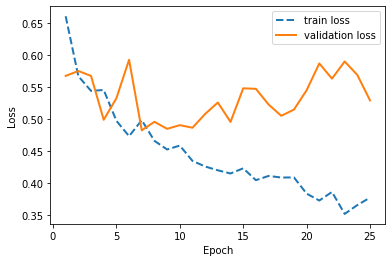

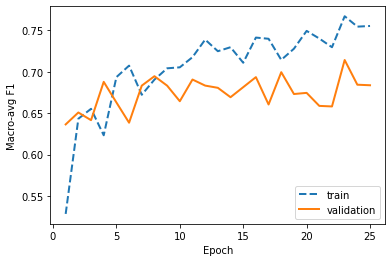

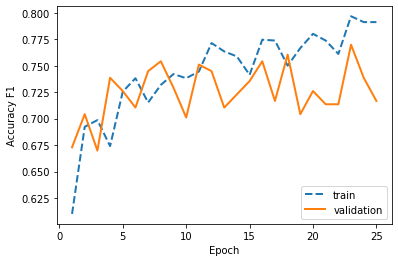

In [39]:
def save_plots(train_losses, val_losses, train_f1, val_f1, train_accs, val_accs):
    """Plot

        Plot two figures: loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_losses)
    xs = np.arange(1,n+1,1)

    # plot train and val losses
    fig, ax = plt.subplots()
    ax.plot(xs, train_losses, '--', linewidth=2, label='train loss')
    ax.plot(xs, val_losses, '-', linewidth=2, label='validation loss')
    #ax.set_xlim(0, 10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc='upper right')
    plt.savefig('data/bert_plot/loss_Bert_Loc_utype_wo_attn.png')

    # plot train and val f1-score
    #plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_f1, '--', linewidth=2, label='train')
    ax.plot(xs, val_f1, '-', linewidth=2, label='validation')
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Macro-avg F1")
    ax.legend(loc='lower right')
    plt.savefig('data/bert_plot/f1_Bert_Loc_utype_wo_attn.png')
    
    # plot train and val accuracy
    #plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_accs, '--', linewidth=2, label='train')
    ax.plot(xs, val_accs, '-', linewidth=2, label='validation')
    #ax.set_xlim(0, 10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy F1")
    ax.legend(loc='lower right')
    plt.savefig('data/bert_plot/acc_Bert_Loc_utype_wo_attn.png')
    
save_plots(per_epoch_train_loss, per_epoch_val_loss, per_epoch_train_f1, per_epoch_val_f1, per_epoch_train_acc, per_epoch_val_acc)

In [40]:
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [41]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.eval()
    
    with torch.no_grad():
    
        #for batch in iterator:
        preds , true_labels = [], []
        for step, batch in enumerate(iterator):    
            text = batch[0].to(device)
            label = batch[2].to(device)

            #predictions = model(batch.text).squeeze(1)
            predictions = model(text)
            
            #loss = criterion(predictions, batch.label)
            loss = criterion(predictions, label)
            #acc = binary_accuracy(predictions, batch.label)
            acc, macro_f1 = binary_accuracy(torch.argmax(predictions, dim = 1), label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_macro += macro_f1.item()
            
            # Store predictions and true labels
            preds.append(torch.argmax(predictions, dim = 1).to('cpu').numpy())
            true_labels.append(label.to('cpu').numpy())
            
                        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator), preds, true_labels

In [42]:
from sklearn.metrics import classification_report

for epoch in range(0,25):
    model.load_state_dict(torch.load('data/bert_twt/model_twt_wo_attn_'+str(epoch+1)+'.pt'))

    test_loss, test_acc, test_f1, pred, label = evaluate(model, test_dataloader, criterion)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.3f} | Test macro-avg-f1: {test_f1*100:.3f}%')
    flat_predictions = np.concatenate(pred, axis=0)
    flat_labels = np.concatenate(label, axis=0)
    
    print(classification_report(flat_labels, flat_predictions, digits=4))

Test Loss: 0.558 | Test Acc: 70.250 | Test macro-avg-f1: 67.395%
              precision    recall  f1-score   support

           0     0.7887    0.5628    0.6569       199
           1     0.6575    0.8477    0.7406       197

    accuracy                         0.7045       396
   macro avg     0.7231    0.7053    0.6987       396
weighted avg     0.7234    0.7045    0.6985       396

Test Loss: 0.582 | Test Acc: 69.250 | Test macro-avg-f1: 66.397%
              precision    recall  f1-score   support

           0     0.6502    0.8593    0.7403       199
           1     0.7895    0.5330    0.6364       197

    accuracy                         0.6970       396
   macro avg     0.7198    0.6961    0.6883       396
weighted avg     0.7195    0.6970    0.6886       396

Test Loss: 0.566 | Test Acc: 66.500 | Test macro-avg-f1: 63.867%
              precision    recall  f1-score   support

           0     0.6754    0.6482    0.6615       199
           1     0.6585    0.6853    0.671

Test Loss: 0.607 | Test Acc: 74.500 | Test macro-avg-f1: 69.969%
              precision    recall  f1-score   support

           0     0.6787    0.9447    0.7899       199
           1     0.9076    0.5482    0.6835       197

    accuracy                         0.7475       396
   macro avg     0.7931    0.7465    0.7367       396
weighted avg     0.7926    0.7475    0.7370       396

Test Loss: 0.650 | Test Acc: 74.750 | Test macro-avg-f1: 69.843%
              precision    recall  f1-score   support

           0     0.6736    0.9749    0.7967       199
           1     0.9537    0.5228    0.6754       197

    accuracy                         0.7500       396
   macro avg     0.8137    0.7489    0.7361       396
weighted avg     0.8130    0.7500    0.7364       396

Test Loss: 0.607 | Test Acc: 75.250 | Test macro-avg-f1: 71.536%
              precision    recall  f1-score   support

           0     0.6988    0.9095    0.7904       199
           1     0.8686    0.6041    0.712

In [43]:
'''
Test Loss: 0.660 | Test Acc: 68.250 | Test macro-avg-f1: 61.566%
Test Loss: 0.637 | Test Acc: 72.500 | Test macro-avg-f1: 67.102%
Test Loss: 0.656 | Test Acc: 69.250 | Test macro-avg-f1: 62.161%
Test Loss: 0.581 | Test Acc: 73.500 | Test macro-avg-f1: 68.485%
Test Loss: 0.616 | Test Acc: 69.750 | Test macro-avg-f1: 62.418%
Test Loss: 0.580 | Test Acc: 73.750 | Test macro-avg-f1: 69.892%
Test Loss: 0.639 | Test Acc: 70.500 | Test macro-avg-f1: 63.049%
Test Loss: 0.574 | Test Acc: 74.000 | Test macro-avg-f1: 69.004%
Test Loss: 0.587 | Test Acc: 71.750 | Test macro-avg-f1: 64.628%
Test Loss: 0.601 | Test Acc: 73.500 | Test macro-avg-f1: 66.236%
'''

'\nTest Loss: 0.660 | Test Acc: 68.250 | Test macro-avg-f1: 61.566%\nTest Loss: 0.637 | Test Acc: 72.500 | Test macro-avg-f1: 67.102%\nTest Loss: 0.656 | Test Acc: 69.250 | Test macro-avg-f1: 62.161%\nTest Loss: 0.581 | Test Acc: 73.500 | Test macro-avg-f1: 68.485%\nTest Loss: 0.616 | Test Acc: 69.750 | Test macro-avg-f1: 62.418%\nTest Loss: 0.580 | Test Acc: 73.750 | Test macro-avg-f1: 69.892%\nTest Loss: 0.639 | Test Acc: 70.500 | Test macro-avg-f1: 63.049%\nTest Loss: 0.574 | Test Acc: 74.000 | Test macro-avg-f1: 69.004%\nTest Loss: 0.587 | Test Acc: 71.750 | Test macro-avg-f1: 64.628%\nTest Loss: 0.601 | Test Acc: 73.500 | Test macro-avg-f1: 66.236%\n'

In [44]:
# 0.0002 > 0.0001 > 0.0005(75%) > 0.0007 > 0.003
# adam 0.001 > 76%